In [8]:
from urllib import request
from io import BytesIO
import re
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

## ___Linear Mixed Effect Models (LMM)___
----------------

In [ ]:
# https://medium.com/@akif.iips/understanding-random-effect-and-fixed-effect-in-statistical-analysis-db4983cdf8b1
# https://stats.oarc.ucla.edu/other/mult-pkg/introduction-to-linear-mixed-models/#:~:text=Linear%20mixed%20models%20are%20an%20extension%20of,within%20classrooms%2C%20or%20patients%20from%20within%20doctors.
# https://m-clark.github.io/mixed-models-with-R/

In [ ]:
# first of all, all of thes are linear models, WE ARE ESSENTIALLY LOOKING AT COMPLEX NON-POLYNOMIAL REGRESSION!!!

In [2]:
# fixed effects - consider a group with groups within, the overarching group will have a common slope shared by all 
# the subgroups, but each subgroup will have its own intercept. This accounts for the unique group specific variations (different biases)

# random effects - using the same example, 

### ___Fixed Effects___
---------

In [ ]:
# a study tries to investigate the efficacy of two different teaching methods in student performance using school students across 
# a set of diferent schools

# the impact teaching method has on student performance is of interest to us
# but there could be other factors influencing the student performance, like there may be school specific factors - mean socioeconomic
# status of the students, mean attendence rates, gender distribution of pupil, facilities available in the school, funding that the said
# school receives to support special-ed students and whatnot

# consider the following linear equation
# score of each student - S_i
# coefficient quantifying the teaching method's influence - lambda
# teaching method - M
# intercept - c
# error term for each student - epsilon_i

## $S_i = \lambda M + c + \varepsilon_i$

In [4]:
# incorporating the school level fixed effects, say that we have 5 different schools A,B, C, D and E
# the ebove equation changes into

## $S_i = \lambda M + \alpha_1 A + \alpha_2 B + \alpha_3 C + \alpha_4 D + c + \varepsilon_i$

In [ ]:
# alpha's are the cognate quantified effects of a student belonging to a select school
# A, B, C, D and E can be understood as a binary variable, switching the correct corresponding coefficient on for each student

#### ___Random Effects___
-----------------

## ___LMM - Implementation___
-------------

In [3]:
groot = pd.read_csv(r"./GRooTFullVersion.csv", low_memory=False, encoding="latin")
colours = pd.Series(cnames.keys())

In [4]:
genera, freq = np.unique(groot.genus.dropna(), return_counts=True)
genera[np.argmax(freq)]

'Pinus'

In [133]:
pinus_specific_root_length = groot.query("genus == 'Pinus' & traitName == 'Specific_root_length'").\
                        loc[:, ["genus", "species", "traitName", "traitValue"]].dropna()

In [134]:
pinus_specific_root_length

,genus,species,traitName,traitValue
1160,Pinus,strobus,Specific_root_length,13.600000
1166,Pinus,strobus,Specific_root_length,4.400000
1368,Pinus,pinaster,Specific_root_length,9.907693
1372,Pinus,pinaster,Specific_root_length,6.300004
1375,Pinus,pinaster,Specific_root_length,6.138464
...,...,...,...,...
106303,Pinus,massoniana,Specific_root_length,23.928400
106310,Pinus,massoniana,Specific_root_length,30.312800
109825,Pinus,canariensis,Specific_root_length,3.070000
109827,Pinus,canariensis,Specific_root_length,2.790000


In [135]:
# we have 22 species in genus Pinus 
pinus_specific_root_length.species.unique().size

22

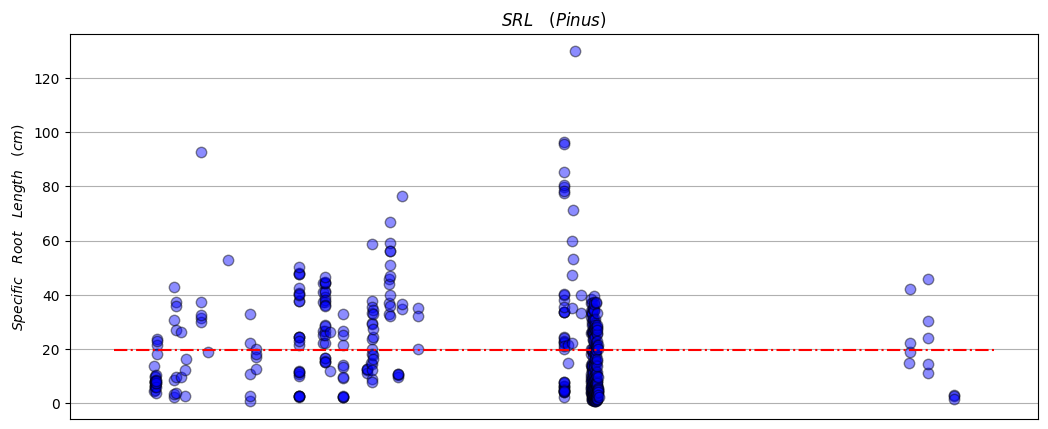

In [136]:
fig, axes = plt.subplots()
fig.set_size_inches(12.5, 5)
axes.set_axisbelow(True)
axes.plot(pinus_specific_root_length.traitValue, linestyle="none", marker="o", markerfacecolor="blue", markeredgecolor="black", markersize=7.5, alpha=0.45)
axes.hlines(y=pinus_specific_root_length.traitValue.mean(), xmin=axes.get_xlim()[0], xmax=axes.get_xlim()[1], color="red", linestyle="-.")
axes.set_xticks([])
axes.grid()
axes.set_title(r"$SRL\hspace{1}(Pinus)$")
axes.set_ylabel(r"$Specific\hspace{1}Root\hspace{1}Length\hspace{1}(cm)$")
plt.show()

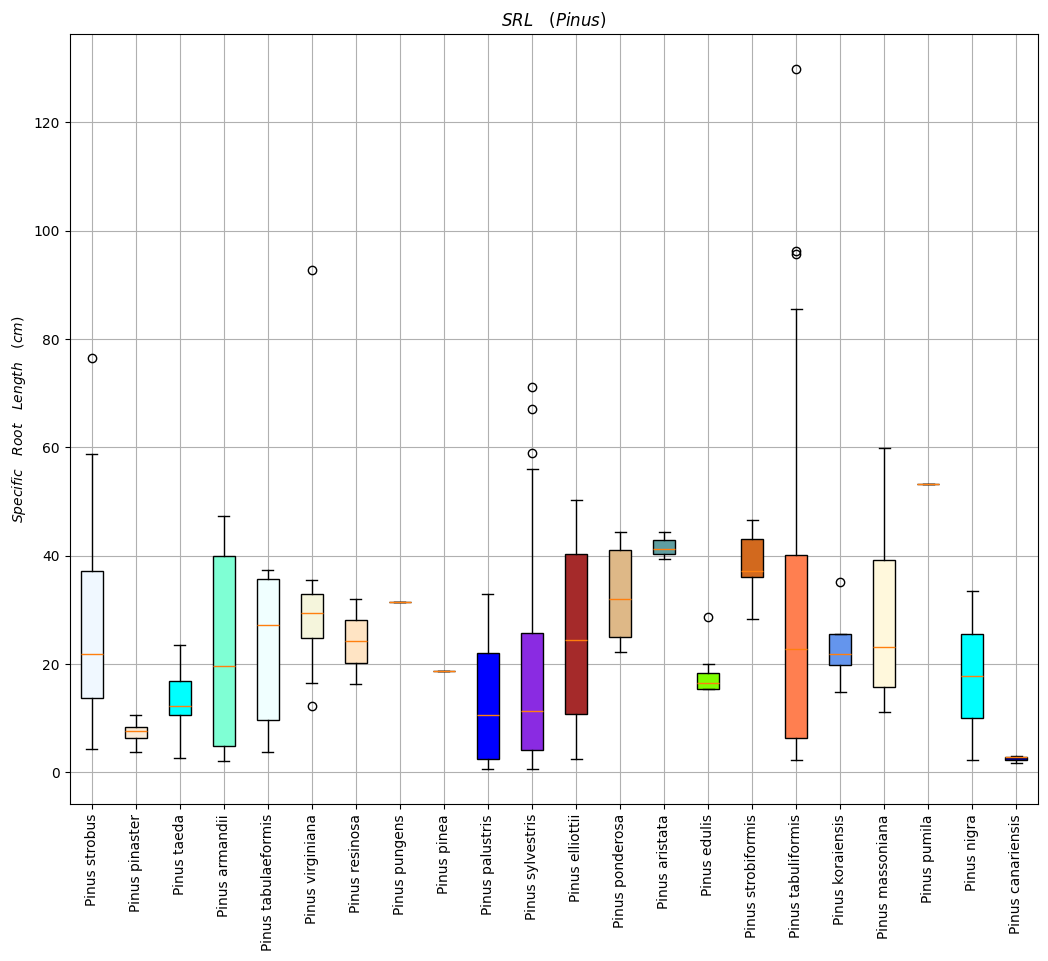

In [141]:
fig, axes = plt.subplots()
fig.set_size_inches(12.5, 10)
axes.set_axisbelow(True)

bplot= axes.boxplot([pinus_specific_root_length.loc[pinus_specific_root_length.species == sp, "traitValue"] for sp in pinus_specific_root_length.species.unique()],
            patch_artist=True)
for i, box in enumerate(bplot.get("boxes")):
    box.set_facecolor(colours[i])
axes.set_xticks(ticks=range(1, 23), labels=[f"Pinus {sp}" for sp in pinus_specific_root_length.species.unique()], rotation=90)
axes.grid()
axes.set_title(r"$SRL\hspace{1}(Pinus)$")
axes.set_ylabel(r"$Specific\hspace{1}Root\hspace{1}Length\hspace{1}(cm)$")
plt.show()

## ___FRED___
---------

In [3]:
fred = pd.read_csv(r"./FRED/FRED3_Entire_Database_2021.csv", low_memory=False, skiprows=range(1,10))
columns = pd.read_csv(r"./FRED/FRED3_Column_Definitions_2021.csv")
columns = pd.Series(index=columns.column_id, data=columns.name.str.lower().str.replace(' ', '_').str.replace('+', "plus").values)
fred.rename(columns={id: name for (id, name) in zip(columns.index, columns.values)}, inplace=True, copy=True)

In [10]:
# Plant taxonomy_Family_Data source
# Plant taxonomy_Genus_Data Source
# Plant taxonomy_Species_Data source
# Plant taxonomy_Subspecies_Data source

fred.columns[fred.columns.str.contains("root_diameter")]

Index(['root_diameter_class_lower_bound', 'root_diameter_class_upper_bound',
       'root_stele_diameter/root_diameter_ratio',
       'n_root_stele_diameter/root_diameter_ratio',
       'se_root_stele_diameter/root_diameter_ratio', 'root_diameter',
       'n_root_diameter', 'se_root_diameter', 'sd_root_diameter',
       'min_root_diameter', 'max_root_diameter', 'median_root_diameter',
       'upper_quartile_root_diameter', 'lower_quartile_root_diameter',
       'modal_root_diameter', 'root_length_fraction_per_root_diameter_class',
       'n_root_length_fraction_per_root_diameter_class',
       'se_root_length_fraction_per_root_diameter_class',
       'root_mass_fraction_per_root_diameter_class',
       'se_root_mass_fraction_per_root_diameter_class',
       'median_root_mass_fraction_per_root_diameter_class',
       'upper_quartile_root_mass_fraction_per_root_diameter_class',
       'lower_quartile_root_mass_fraction_per_root_diameter_class',
       'min_root_mass_fraction_per_root_dia

In [214]:
fred.query("plant_taxonomy_genus_data_source == 'Pinus'").loc[:, ["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source",
                                                                  "root_order", "root_age", "root_diameter"]].isna().mean()

plant_taxonomy_genus_data_source      0.000000
plant_taxonomy_species_data_source    0.001277
root_order                            0.749936
root_age                              0.989783
root_diameter                         0.859004
dtype: float64

In [221]:
np.unique(fred.plant_taxonomy_genus_data_source[fred.plant_taxonomy_family_data_source == "Pinaceae"].dropna(), return_counts=True)

(array(['Abies', 'Larix', 'Picea', 'Pinus', 'Tsuga'], dtype=object),
 array([  5,  33,  28, 120,   5]))

In [11]:
# subset contains root trait records of two genera in family Pinaceae
subset = fred.query("plant_taxonomy_genus_data_source == 'Pinus' | plant_taxonomy_genus_data_source == 'Larix'").loc[:, ["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source",
                                                                  "root_order", "root_diameter"]].dropna()

In [12]:
subset

,plant_taxonomy_genus_data_source,plant_taxonomy_species_data_source,root_order,root_diameter
109,Larix,gmelinii,1.0,0.3500
110,Larix,gmelinii,2.0,0.6800
111,Larix,gmelinii,1.0,0.3300
112,Larix,gmelinii,2.0,0.4200
113,Larix,gmelinii,3.0,0.5300
...,...,...,...,...
54986,Pinus,sylvestris,5.0,0.7774
55110,Pinus,palustris,5.0,1.5600
55111,Larix,gmelinii,5.0,1.7000
55114,Pinus,tabuliformis,5.0,1.2600


In [14]:
# subset.loc[:, ["root_order","root_diameter"]].groupby("root_order").mean()

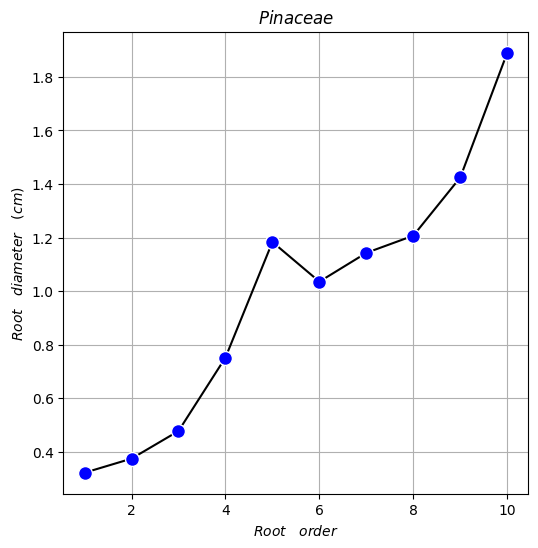

In [16]:
# irrespective of phylogenetic signals

fig, axes = plt.subplots()
fig.set_size_inches(6, 6)
axes.plot(subset.loc[:, ["root_order","root_diameter"]].groupby("root_order").mean(), marker="o", color="black", markerfacecolor="blue",
         markeredgecolor="white", markersize=10)
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.set_ylabel(r"$Root\hspace{1}diameter\hspace{1}(cm)$")
axes.set_title(r"$Pinaceae$")
axes.grid()
plt.show()

In [27]:
subset.groupby(["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source"]).mean()

root_order  root_diameter
plant_taxonomy_genus_data_source plant_taxonomy_species_data_source                           
Larix                            gmelinii                              2.913669       0.729072
                                 kaempferi                             3.000000       0.601000
                                 principis-rupprechtii                 3.000000       0.612050
Pinus                            armandii                              2.666667       0.536519
                                 edulis                                1.000000       0.380000
                                 elliottii                             3.000000       0.607188
                                 koraiensis                            2.677419       0.848452
                                 massoniana                            1.000000       0.290900
                                 palustris                             3.333333       0.851667
                                 pumila                                1.000000       0.282300
                                 resinosa                              1.000000       0.250000
                                 strobus                               2.166667       0.628956
                                 sylvestris                            4.356557       0.708974
                                 tabulaeformis                         3.000000       0.563161
                                 tabuliformis                          3.000000       0.613562
                                 taeda                                 3.000000       0.557783
                                 virginiana                            2.357143       0.310885

In [18]:
model = LinearRegression(n_jobs=cpu_count())
model.fit(subset.root_order.to_numpy().reshape(-1, 1), subset.root_diameter)

LinearRegression(n_jobs=18)

In [19]:
model.coef_, model.intercept_

(array([0.16721871]), np.float64(0.10195304096383806))

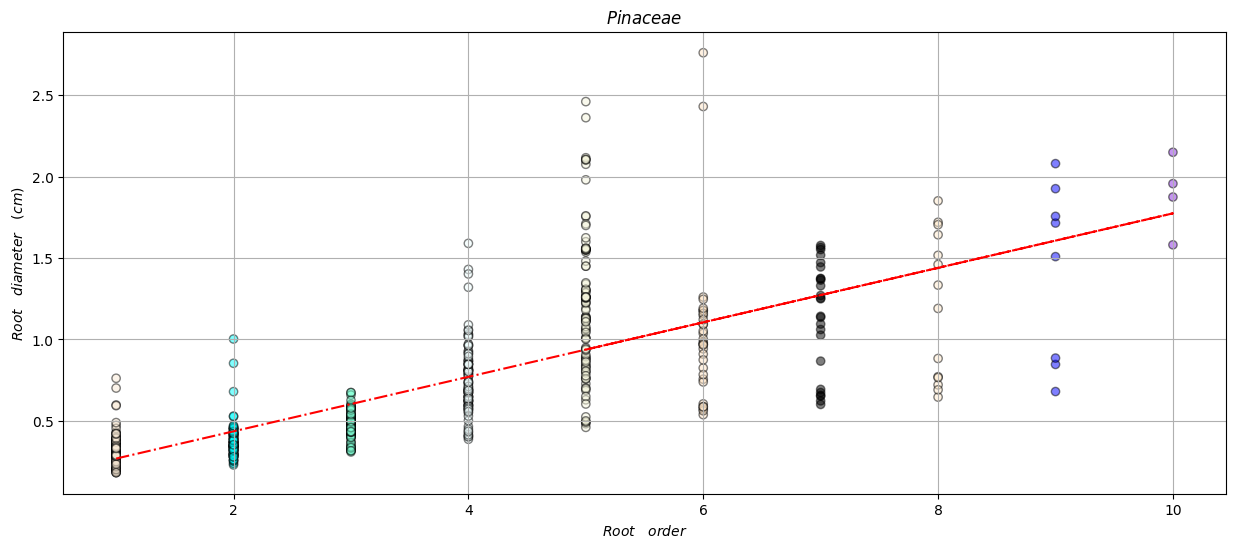

In [27]:
# a crude regression fit for the all records
fig, axes = plt.subplots()
fig.set_size_inches(15, 6)
axes.scatter(subset.root_order, subset.root_diameter, c=list(map(lambda digit: colours[digit], subset.root_order)),
             edgecolor="black", alpha=0.5)
axes.plot(subset.root_order, subset.root_order * model.coef_ + model.intercept_, linestyle="-.", color="red")
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.set_ylabel(r"$Root\hspace{1}diameter\hspace{1}(cm)$")
axes.set_title(r"$Pinaceae$")
axes.grid()
plt.show()

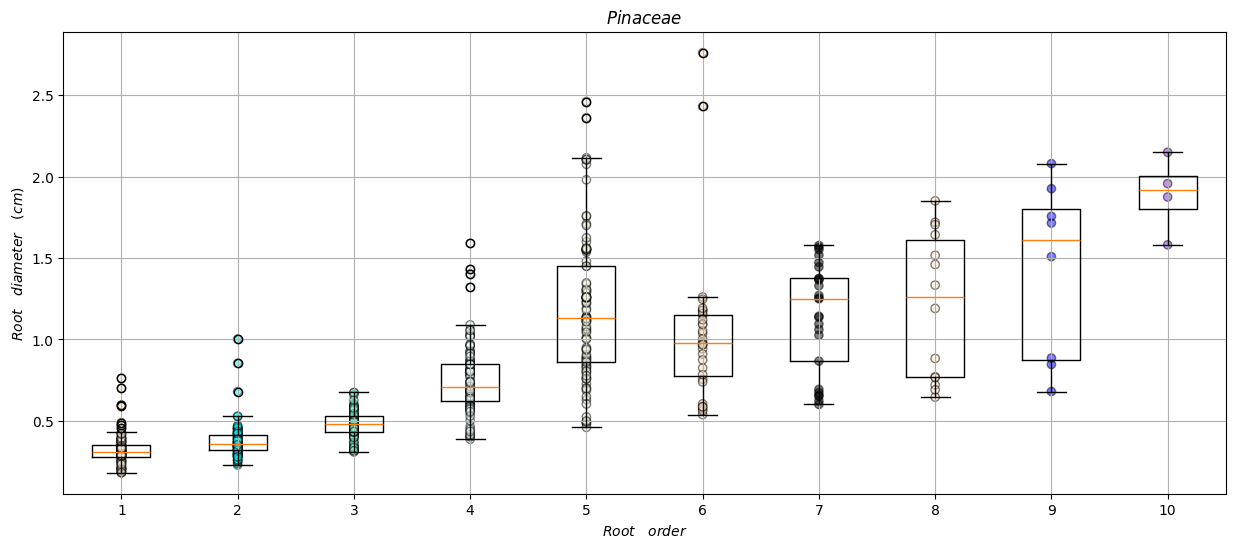

In [30]:
fig, axes = plt.subplots()
fig.set_size_inches(15, 6)
axes.scatter(subset.root_order, subset.root_diameter, c=list(map(lambda digit: colours[digit], subset.root_order)), edgecolor="black",
             alpha=0.5)
axes.boxplot([subset.root_diameter[subset.root_order == i] for i in range(1, 11)])
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.set_ylabel(r"$Root\hspace{1}diameter\hspace{1}(cm)$")
axes.set_title(r"$Pinaceae$")
axes.grid()
plt.show()

In [31]:
# prediction accuracy - correlation coefficient
pearsonr(model.predict(subset.root_order.to_numpy().reshape(-1, 1)), subset.root_diameter)

PearsonRResult(statistic=np.float64(0.7634067412803582), pvalue=np.float64(1.6626435238682044e-121))

In [43]:
subset_binominal = subset.loc[:, ["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source"]].\
                                apply(lambda row: ' '.join(row), axis=1).unique()
subset_binominal.size

17

In [44]:
pd.Series(subset_binominal).str.contains("Larix").sum(), pd.Series(subset_binominal).str.contains("Pinus").sum()

(np.int64(3), np.int64(14))

In [45]:
with pd.option_context("display.max_rows", None):
    print(fred.loc[:, ["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source",
             "root_order", "root_diameter"]].dropna().groupby(["plant_taxonomy_genus_data_source",
                                                               "plant_taxonomy_species_data_source"]).count())


                                                                     root_order  \
plant_taxonomy_genus_data_source plant_taxonomy_species_data_source               
Abelia                           biflora                                      1   
Abies                            faxoniana                                    8   
                                 nephrolepis                                  1   
Acacia                           auriculiformis                              11   
                                 crassicarpa                                  1   
                                 mangium                                      1   
Acer                             barbinerve                                   1   
                                 campbellii                                   1   
                                 caudatum                                     1   
                                 cinnamomifolium                              3   
    

In [51]:
fred.query("plant_taxonomy_genus_data_source == 'Fraxinus' & plant_taxonomy_species_data_source == 'mandshurica'").\
        loc[:, "plant_taxonomy_family_data_source"].dropna().unique()

array(['Oleaceae'], dtype=object)

In [46]:
# including Fraxinus mandshurica (Oleaceae)
superset = pd.concat([fred.query("plant_taxonomy_genus_data_source == 'Fraxinus' & plant_taxonomy_species_data_source == 'mandshurica'").\
                      loc[:, ["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source", "root_order", "root_diameter"]].\
                      dropna(), subset])

In [47]:
superset

,plant_taxonomy_genus_data_source,plant_taxonomy_species_data_source,root_order,root_diameter
107,Fraxinus,mandshurica,1.0,0.3200
108,Fraxinus,mandshurica,2.0,0.5600
141,Fraxinus,mandshurica,1.0,0.2700
142,Fraxinus,mandshurica,2.0,0.3600
143,Fraxinus,mandshurica,3.0,0.4700
...,...,...,...,...
54986,Pinus,sylvestris,5.0,0.7774
55110,Pinus,palustris,5.0,1.5600
55111,Larix,gmelinii,5.0,1.7000
55114,Pinus,tabuliformis,5.0,1.2600


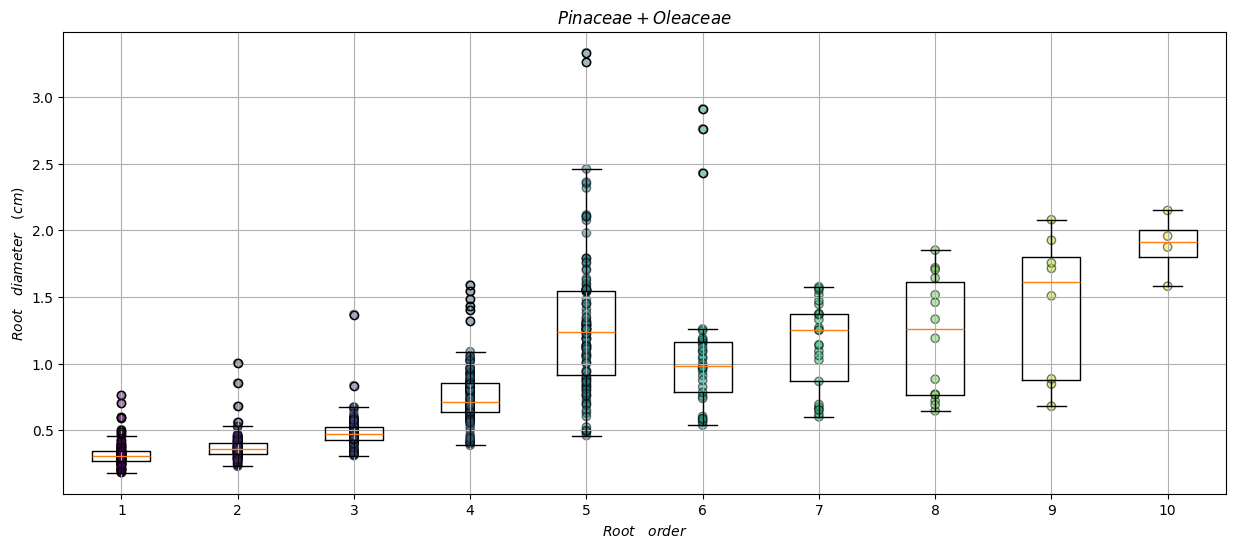

In [53]:
fig, axes = plt.subplots()
fig.set_size_inches(15, 6)
axes.scatter(superset.root_order, superset.root_diameter, c=superset.root_order, edgecolor="black", alpha=0.5)
axes.boxplot([superset.root_diameter[superset.root_order == i] for i in range(1, 11)])
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.set_ylabel(r"$Root\hspace{1}diameter\hspace{1}(cm)$")
axes.set_title(r"$Pinaceae + Oleaceae$")
axes.grid()
plt.show()

In [128]:
model = LinearRegression(n_jobs=cpu_count())
model.fit(superset.root_order.to_numpy().reshape(-1, 1), superset.root_diameter)

LinearRegression(n_jobs=18)

In [129]:
pearsonr(model.predict(superset.root_order.to_numpy().reshape(-1, 1)), superset.root_diameter)

PearsonRResult(statistic=np.float64(0.7384437822604188), pvalue=np.float64(2.4292928280472173e-131))

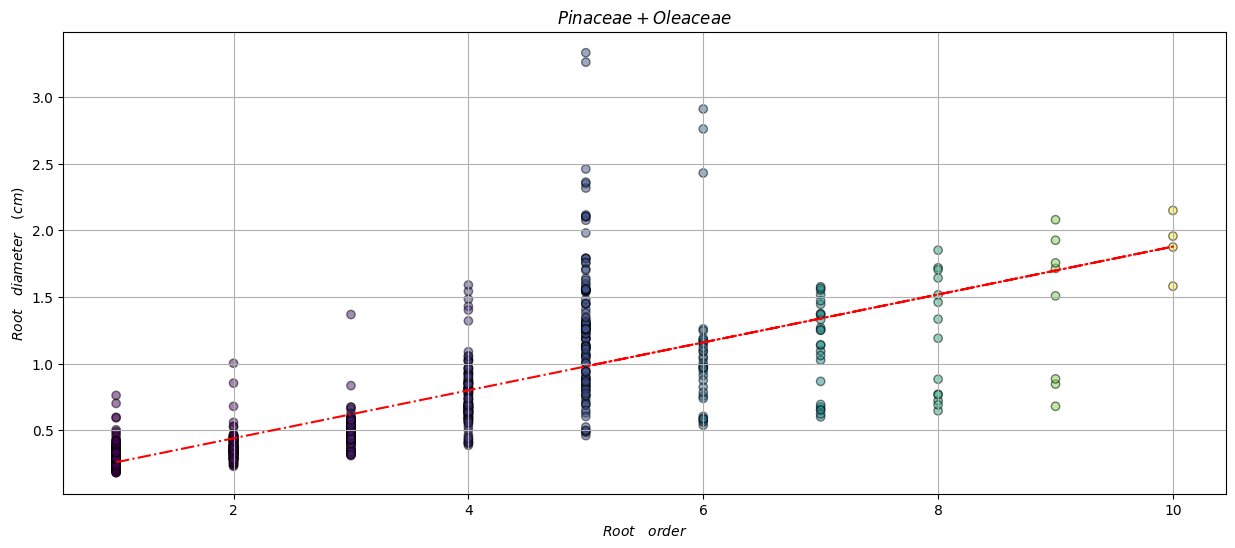

In [130]:
fig, axes = plt.subplots()
fig.set_size_inches(15, 6)
axes.scatter(superset.root_order, superset.root_diameter, c=np.square(superset.root_order), edgecolor="black", alpha=0.5)
axes.plot(superset.root_order, superset.root_order * model.coef_ + model.intercept_, linestyle="-.", color="red")
axes.set_xlabel(r"$Root\hspace{1}order$")
axes.set_ylabel(r"$Root\hspace{1}diameter\hspace{1}(cm)$")
axes.set_title(r"$Pinaceae + Oleaceae$")
axes.grid()
plt.show()

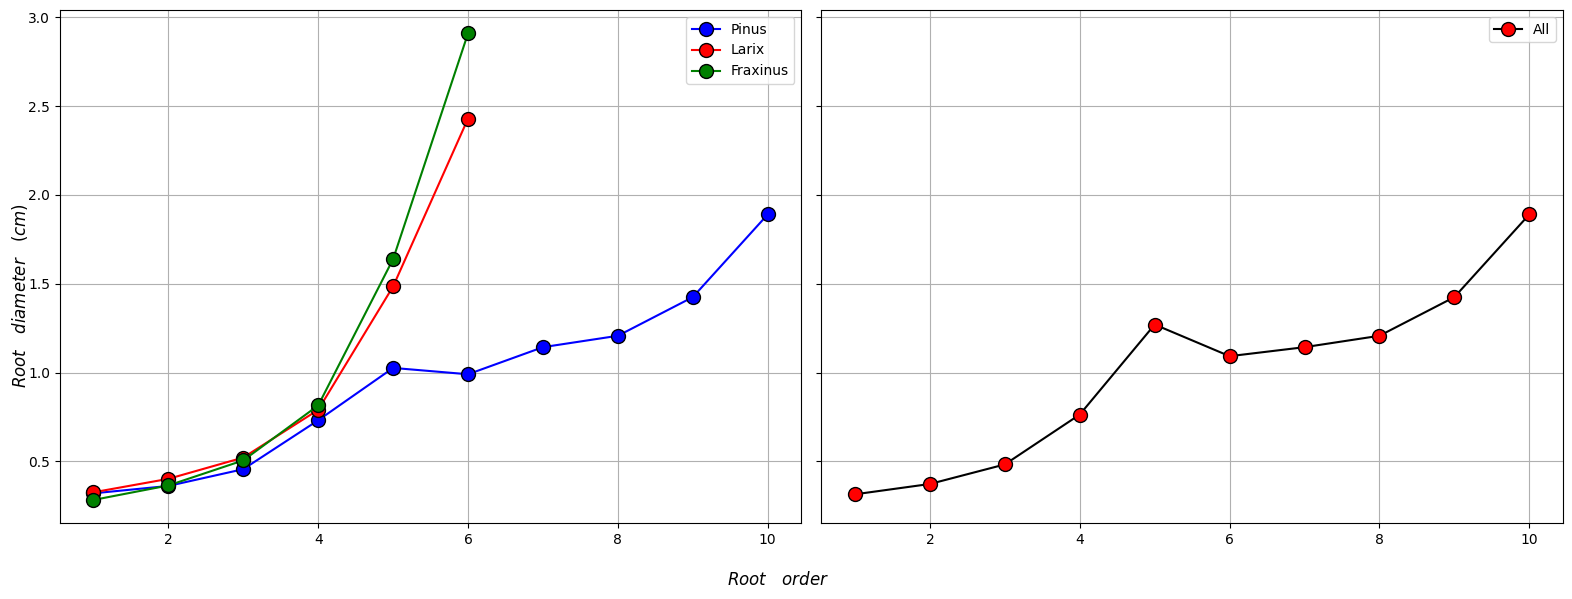

In [86]:
fig, (axes_0, axes_1) = plt.subplots(ncols=2, sharey=True, sharex=True)
fig.set_size_inches(16, 6)
axes_0.plot(subset.query("plant_taxonomy_genus_data_source == 'Pinus'").loc[:, ["root_order","root_diameter"]].groupby("root_order").mean(),
          marker="o", color="blue", markerfacecolor="blue", markeredgecolor="black", markersize=10, label="Pinus")
axes_0.plot(superset.query("plant_taxonomy_genus_data_source == 'Larix'").loc[:, ["root_order","root_diameter"]].groupby("root_order").mean(),
          marker="o", color="red", markerfacecolor="red", markeredgecolor="black", markersize=10, label="Larix")
axes_0.plot(superset.query("plant_taxonomy_genus_data_source == 'Fraxinus'").loc[:, ["root_order","root_diameter"]].groupby("root_order").mean(),
          marker="o", color="green", markerfacecolor="green", markeredgecolor="black", markersize=10, label="Fraxinus")
axes_0.legend()
axes_0.grid()
axes_1.plot(superset.loc[:, ["root_order","root_diameter"]].groupby("root_order").mean(), marker="o", color="black", markerfacecolor="red",
          markersize=10, label="All")
axes_1.legend()
axes_1.grid()
fig.supylabel(r"$Root\hspace{1}diameter\hspace{1}(cm)$")
fig.supxlabel(r"$Root\hspace{1}order$")
plt.tight_layout()
plt.show()

In [87]:
# pinus seems to overshadow the other genera!!!
superset.groupby("plant_taxonomy_genus_data_source").count()

,plant_taxonomy_species_data_source,root_order,root_diameter
plant_taxonomy_genus_data_source,,,
Fraxinus,126,126,126
Larix,184,184,184
Pinus,447,447,447


In [138]:
# unevenness
superset.groupby(["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source"])["root_diameter"].count()

plant_taxonomy_genus_data_source  plant_taxonomy_species_data_source
Fraxinus                          mandshurica                           126
Larix                             gmelinii                              139
                                  kaempferi                              40
                                  principis-rupprechtii                   5
Pinus                             armandii                                6
                                  edulis                                  1
                                  elliottii                              32
                                  koraiensis                             31
                                  massoniana                              1
                                  palustris                               6
                                  pumila                                  1
                                  resinosa                                1
                   

In [92]:
superset.groupby(["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source", "root_order"]).mean()

root_diameter
plant_taxonomy_genus_data_source plant_taxonomy_species_data_source root_order               
Fraxinus                         mandshurica                        1.0              0.282753
                                                                    2.0              0.364317
                                                                    3.0              0.505525
                                                                    4.0              0.814784
                                                                    5.0              1.638925
...                                                                                       ...
Pinus                            virginiana                         1.0              0.227836
                                                                    2.0              0.260803
                                                                    3.0              0.339266
                                                                    4.0              0.436652
                                                                    5.0              0.604112

[82 rows x 1 columns]

In [100]:
# plot all 18 species individually

superset.loc[:,  "plant_taxonomy_species_data_source"].unique().size

18

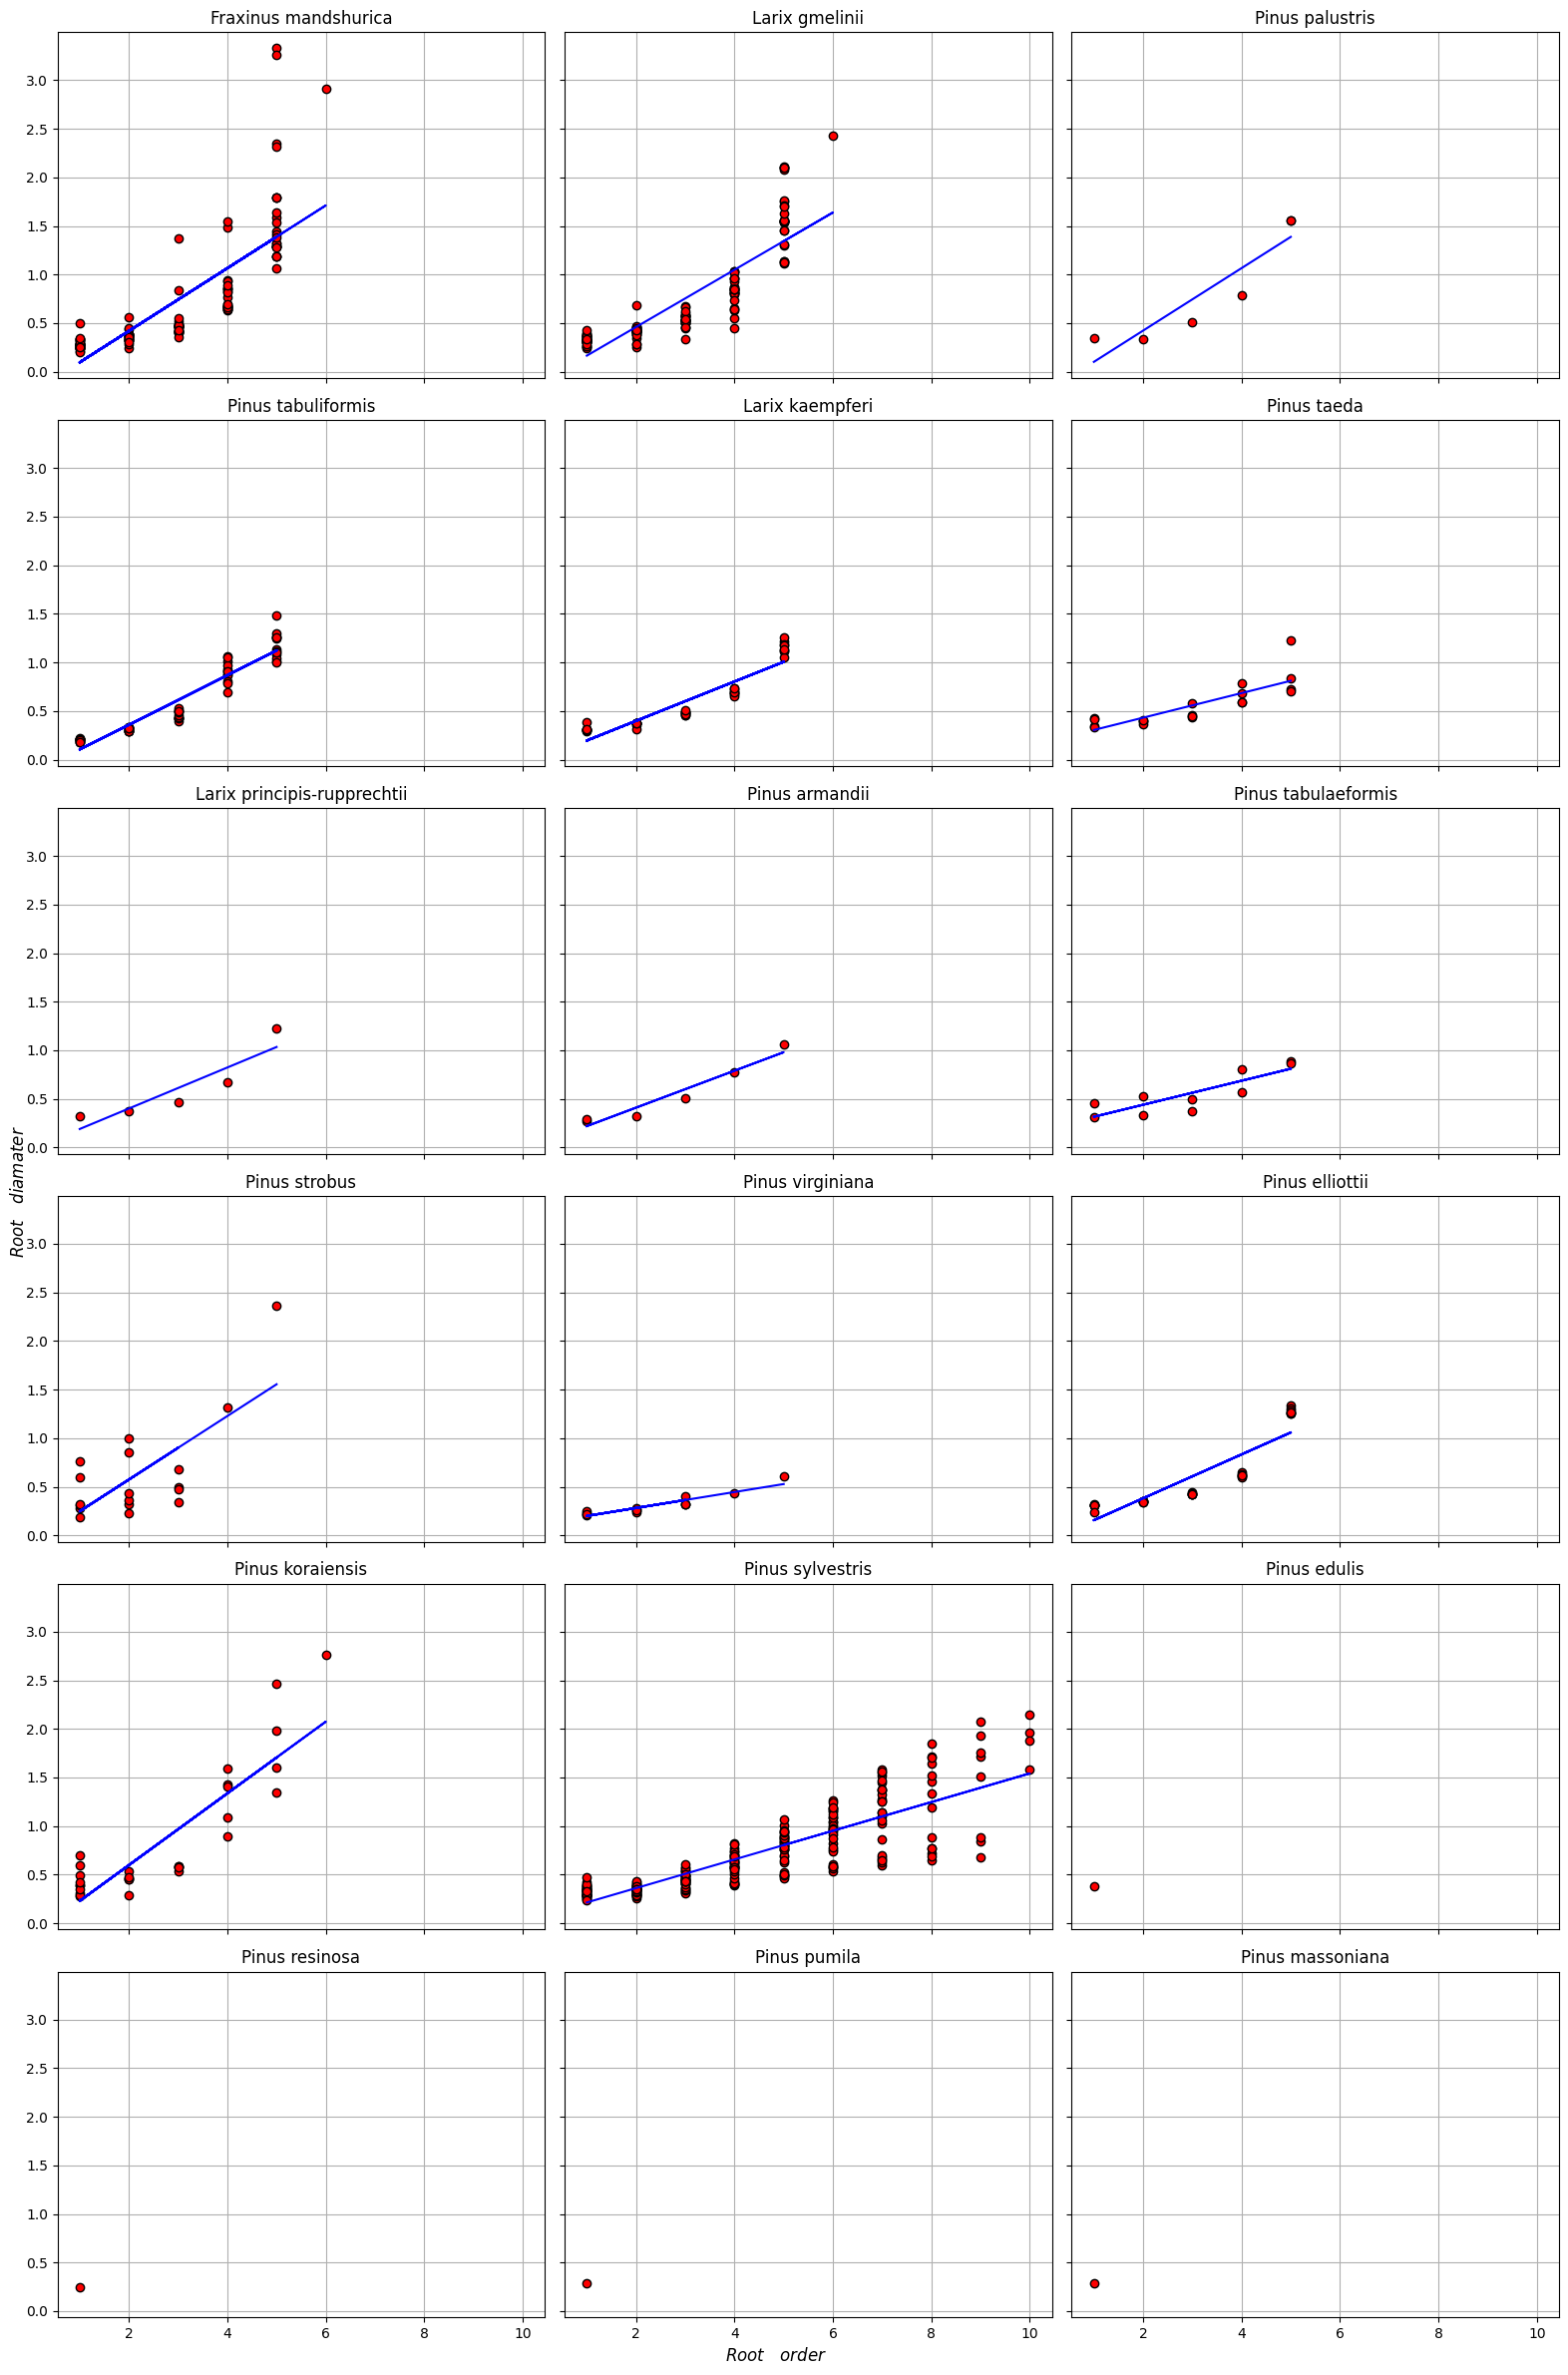

In [132]:
fig, axes_18 = plt.subplots(nrows=6, ncols=3, sharey=True, sharex=True)
fig.set_size_inches(16, 24)

taxonomy = superset.loc[:, ["plant_taxonomy_genus_data_source", "plant_taxonomy_species_data_source"]].drop_duplicates()
for (axes, genus, species) in zip(axes_18.flatten(), taxonomy.plant_taxonomy_genus_data_source, taxonomy.plant_taxonomy_species_data_source):
    temp = superset.query(f"plant_taxonomy_genus_data_source == '{genus}' & plant_taxonomy_species_data_source == '{species}'")
    axes.plot(temp.loc[:, "root_order"], temp.loc[:, "root_diameter"], marker="o", linestyle="none", mfc="red", mec="black")
    axes.set_title(f"{genus} {species}")
    axes.grid()
    model = LinearRegression(n_jobs=1)
    model.fit(temp.root_order.to_numpy().reshape(-1, 1), temp.root_diameter)
    axes.plot(temp.root_order, temp.root_order * model.coef_ + model.intercept_, linestyle="-", color="blue")
    
fig.supxlabel(r"$Root\hspace{1}order$")
fig.supylabel(r"$Root\hspace{1}diamater$")
plt.tight_layout()
plt.show()

In [ ]:
# partial residues 
# partial residue plots

# including random slopes
# .... + random intercepts
# ....... if there's a correlation between the intercepts and slopes

# WTF are residuals???

In [9]:
# root_n_content - conservation gradient (acquisitive end)
# root_tissue_density_(rtd) - conservation gradient (conservative end)

np.unique(fred.loc[:, ["plant_taxonomy_family_data_source", "root_n_content", "root_tissue_density_(rtd)"]].\
            dropna().groupby("plant_taxonomy_family_data_source")["plant_taxonomy_family_data_source"].values, return_counts=True)

AttributeError: 'SeriesGroupBy' object has no attribute 'values'

## ___Tensorflow Example___
-------------

In [19]:
# using pytorch because why not

with request.urlopen(r"https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/lme4/InstEval.csv") as req:
     insteval = pd.read_csv(BytesIO(req.read()), low_memory=False, encoding="ascii", index_col=0).reset_index(drop=True)

In [20]:
insteval

,s,d,studage,lectage,service,dept,y
0,1,1002,2,2,0,2,5
1,1,1050,2,1,1,6,2
2,1,1582,2,2,0,2,5
3,1,2050,2,2,1,3,3
4,2,115,2,1,0,5,2
...,...,...,...,...,...,...,...
73416,2972,2034,4,1,1,6,3
73417,2972,2079,4,3,1,11,4
73418,2972,2084,4,1,0,10,5
73419,2972,2110,4,2,1,4,1
